## Predicting

**Importing librairies**


In [71]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt


from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.keras import BalancedBatchGenerator
from imblearn.under_sampling import NearMiss

import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
import geopandas as gpd


https://medium.com/digital-catapult/dealing-with-imbalanced-data-8b21e6deb6cd

**Importing data**

In [67]:
filename_1 = "..\data\_tarefelt1.csv"
filename_2 = "..\data\_tarefelt2.csv"
filename_3 = "..\data\_tarefelt3.csv"

In [68]:
data_1 = pd.read_csv(filename_1)
data_2 = pd.read_csv(filename_2)
data_3 = pd.read_csv(filename_3)

X =  pd.concat([data_1, data_2, data_3])
lat, lon = X.drop(columns = "lat"), X.drop(columns =  "lon") 
y = X.label

In [69]:
X.drop(columns = ['lat','lon', 'geometry', 'label'], inplace = True)

**Splitting data**

Creating balanced datasets using stratified shuffle split

In [65]:
X_train, X_test ,y_train, y_test = train_test_split( data_x, data_y, test_size=0.30, random_state=42)
X_test, X_val ,y_test, y_val = train_test_split( X_test, y_test, test_size=0.5, random_state=42)

**Using imbalanced**

**Training the model**  


In [41]:
def batch(iterable_X, iterable_y, n=1):
    '''
    n: batchsize
    
    '''
    l = len(iterable_X)
    for ndx in range(0, l, n):
        yield iterable_X[ndx:min(ndx + n, l)], iterable_y[ndx:min(ndx + n, l)]


Fold 0:
  Train: index=[  81542 1952092 1220374 ...  370541  570150 1738877]
  Test:  index=[ 244512  877894 2381792 ... 1522318  832019  228638]


'\n    for index, (X, target) in enumerate(batcherator):\n\n        print(count)\n        count+= 1\n        #Using a standardscaler\n        scaler = StandardScaler()\n        scaler.fit(X) \n        X = scaler.transform(X)\n        test = scaler.transform(X_val) \n        clf.partial_fit(X, target, classes)\n        y_predicted = clf.predict(test)\n        accuracy.append(accuracy_score(y_val, y_predicted))\n'

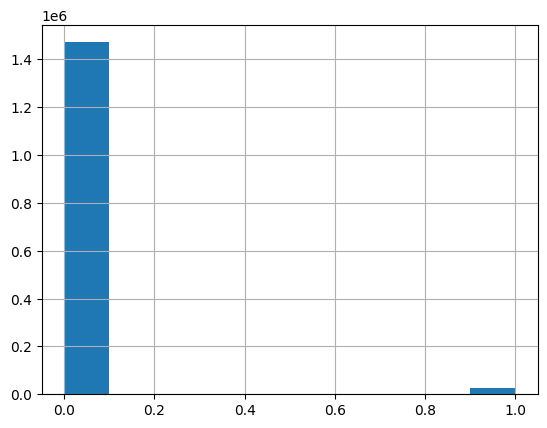

In [74]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
clf = SGDClassifier(loss = "log_loss",  verbose = 50, warm_start = True, penalty = "elasticnet", max_iter=1000, tol=1e-3, class_weight= dict(zip(np.unique(y_train), class_weights)))

classes = np.unique(y_train)
accuracy =[]
ROUNDS = 1
count = 0 
batch_size = 10000

sss = StratifiedShuffleSplit(n_splits=ROUNDS, test_size=0.5, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    
    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    

    batcheratorbatch(iterable_X, iterable_y, n=1)

    for index, (X, target) in enumerate(batcherator):

        print(count)
        count+= 1
        #Using a standardscaler
        scaler = StandardScaler()
        scaler.fit(X) 
        X = scaler.transform(X)
        test = scaler.transform(X_val) 
        clf.partial_fit(X, target, classes)
        y_predicted = clf.predict(test)
        accuracy.append(accuracy_score(y_val, y_predicted))
'''

**Plotting accuracy**

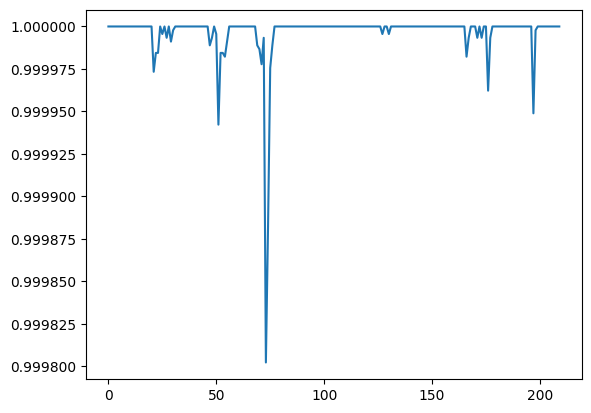

In [44]:
plt.plot(accuracy)

**Evaluating Model**


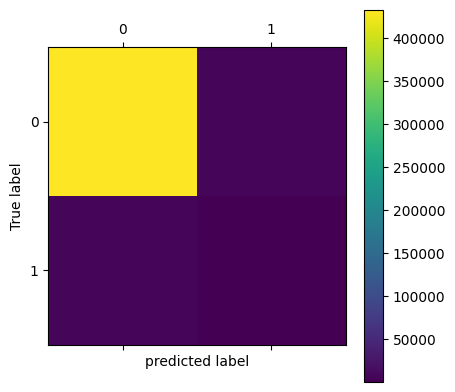

In [45]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)
# Plot matrix
plt.matshow(conf_mat)
plt.colorbar()
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

**Checking over the test set**

In [50]:
y_predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print(f"The accuracy of the model was {np.round(accuracy,2)}")

The accuracy of the model was 0.02


In [58]:
np.unique(y_predicted)

array([1.])

In [51]:
y_test.value_counts()


0.0    441502
1.0      8498
Name: label, dtype: int64

<AxesSubplot:>

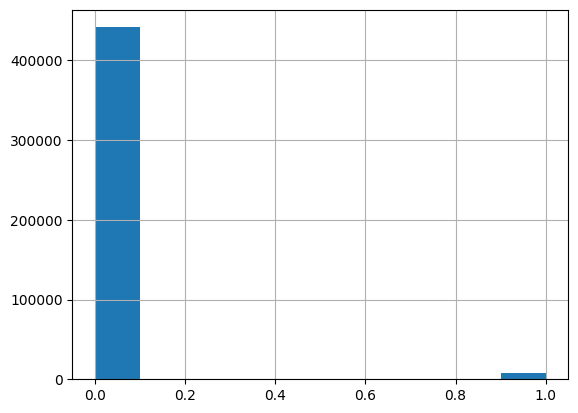

In [54]:
y_test.hist()

**Plotting the predicted seaweed and comparing with naturdirektoratet**

(604766    7.495095
 945153    7.417553
 910595    4.527858
 454799    8.409257
 471955    7.534781
             ...   
 169451    8.634998
 40819     4.957982
 217719    8.558129
 549560    8.399874
 883799    8.166645
 Name: lon, Length: 450000, dtype: float64,)

In [48]:
X = X_test.copy()
X["label"] = y_test
X["y_predicted"] = y_predicted
X = gpd.GeoDataFrame(X, geometry=gpd.points_from_xy(X.lon, X.lat))

df_no_seaweed = X[X["y_predicted"] == 0].copy()
df_seaweed = X[X["y_predicted"] == 1].copy()
df_true_seaweed = X[X["label"] == True].copy()

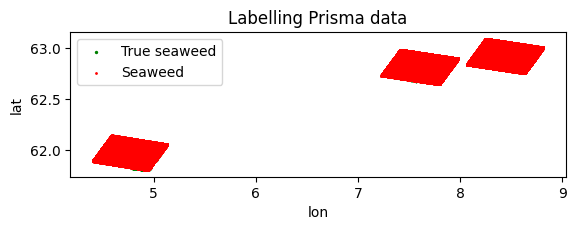

In [52]:
fig, ax = plt.subplots()
df_no_seaweed.plot(ax = ax, color = "blue", label = "no seaweed")
df_true_seaweed.plot(ax = ax, color = "green", label = "True seaweed", markersize = 2)
df_seaweed.plot(ax = ax, color = "red", label = "Seaweed", markersize = 1)

ax.set_title("Labelling Prisma data")
ax.set_xlabel("lon")
ax.set_ylabel("lat")
ax.legend()